In [123]:
## loading required libraries
import math
import re
import sys
import time
import json
import itertools
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.sparse import csr_matrix
import pickle as pkl

In [124]:
# Global variables
START_TOKEN = "<start>"
STOP_TOKEN = "<stop>"
UNK_TOKEN = '<unk>'

In [125]:
# reading file given filepath, not very much used
def read_file(filepath):
    with open(filepath, 'r') as f:
        data = f.readlines()
    return data

In [126]:
data = read_file('conll03_ner/eng.train.small')

count = 0
for i in range(len(data)):
    if len(data[i].strip().split()) < 4:
        count += 1
print (count)

3000


In [127]:
# to read file line by line and return a list containing sentences. Sentences contain tuples of 4 objects
def read_file_linebyline(filepath):
    
    with open(filepath, 'r') as f:
        data = f.readlines()
    
    all_sentences = []
    sent = []
     
    for line in data:
        columns = line.strip().split()
        if len(columns) == 4:
            if '-DOCSTART-' not in columns:
                sent.append(tuple(columns))
        else:
            all_sentences.append(sent)
            sent = []
    return all_sentences

In [128]:
dev_sentences = read_file_linebyline('conll03_ner/eng.dev.small')
train_sentences = read_file_linebyline('conll03_ner/eng.train.small')

In [196]:
ner_tags = {}
unigrams = set()

In [197]:
# defining REGEX for various unigram based features (local)

HAS_NUM = re.compile(r'\w+\d+\w+')
IS_NUM = re.compile(r'[+-]?\d+(\,\d+)?\.?\d*$')
IS_INT = re.compile(r'\d+$')


HAS_HYPHEN = re.compile(r'[a-zA-Z]+\-[a-zA-Z]+')
IS_HYPHEN = re.compile(r'\-+')

HAS_PERIOD = re.compile(r'[a-zA-Z]+\.$')
IS_PERIOD = re.compile(r'\.+')

HAS_APOS = re.compile(r'\w+\'\w+')
HAS_DAPOS = re.compile(r'\w+\"\w+')
IS_APOS = re.compile(r'\'')
IS_DAPOS = re.compile(r'\"')

HAS_COLON = re.compile(r'\w+\:\w+') 
IS_COLON = re.compile(r'\:')
HAS_SCOLON = re.compile(r'\w+\;\w+')
IS_SCOLON = re.compile(r'\;')

VERB_S = re.compile('\w+s$')
VERB_ED = re.compile('\w+ed$')
VERB_ING = re.compile('\w+ing$')
                       
ALL_CAPS = re.compile(r'[A-Z]+$')
FIRST_CAP = re.compile(r'[A-Z][a-z]+')
SINGLE_CAP = re.compile(r'[A-Z]$')
IN_BETWEEN_CAPs = re.compile(r'[A-Z]+[a-z]+[A-Z]+[a-z]+')

word_based_features = ['has_num', 'is_num', 'is_int', 'has_hyphen', 'is_hyphen', 'has_period', 'is_period',
                       'has_apos', 'has_dapos', 'is_apos', 'is_dapos', 'has_colon', 'is_colon', 'has_scolon',
                       'is_scolon', 'verb_s', 'verb_ed', 'verb_ing', 'all_caps',
                       'first_cap', 'single_cap', 'in_between_caps']

In [198]:
features_dict = {}
remove_threshold = 3

In [199]:
# just initialization, initializing a features dictionary as we parse through the data and creating 
# various unigram based features

def create_feature_dict(data):
    
    unigrams_ne = {}
    len_ne = {}
    pos_ne = {}
    synchunk_ne = {}
    suffix_ne = {}
    prefix_ne = {}
    xxxxx_ne = {}
    xxxxx_no_ne = {}
    count_xxxxx_ne = {}
    count_xxxxx_no_ne = {}
    
    for line in data:
        columns = line.strip().split()
        if len(columns) == 4:
            if '-DOCSTART-' not in columns:
                ner = columns[3]
                m_ner = "_" + ner
                ner_tags[ner] = ner_tags.get(ner, 0) + 1
                
                word = columns[0]
                l_word = re.sub('\d', '0', word).lower()
                
                unigram_ne = l_word + m_ner
                unigrams_ne[unigram_ne] = unigrams_ne.get(unigram_ne, 0) + 1
                
                le_ne = str(len(word)) + m_ner
                len_ne[le_ne] = len_ne.get(le_ne, 0) + 1
                
                for feature in word_based_features:
                    feature = feature + m_ner
                    features_dict[feature] = features_dict.get(feature, 0) + 1

                    
                for feature in word_based_features:
                    features_dict[feature] = features_dict.get(feature, 0) + 1

                pos = columns[1] + m_ner
                pos_ne[pos] = pos_ne.get(pos, 0) + 1
                
                synchunk = columns[2] + m_ner
                synchunk_ne[synchunk] = synchunk_ne.get(synchunk, 0) + 1
                
                
                xxxxx = re.sub('[A-Z]', 'X', word)
                xxxxx = re.sub('[a-z]', 'x', xxxxx)
                xxxxx = re.sub('#', '#', xxxxx)
                xxxxx = re.sub('[0-9]', '0', xxxxx)
                xxxxx = re.sub('[^a-zA-Z0-9#]', '.', xxxxx)
                
                xxxxx_no_ne[xxxxx] = xxxxx_no_ne.get(xxxxx, 0) + 1
                xxxxx_ne[xxxxx+m_ner] = xxxxx_ne.get(xxxxx+m_ner, 0) + 1

                count_xxxxx = re.sub('X+', 'X', xxxxx)
                count_xxxxx= re.sub('x+', 'x', count_xxxxx)
                count_xxxxx = re.sub('#+', '#', count_xxxxx)
                count_xxxxx = re.sub('0+', '0', count_xxxxx)
                count_xxxxx = re.sub('\.+', '.', count_xxxxx)
                
                count_xxxxx_no_ne[count_xxxxx] = count_xxxxx_no_ne.get(count_xxxxx, 0) + 1
                count_xxxxx_ne[count_xxxxx+m_ner] = count_xxxxx_ne.get(count_xxxxx+m_ner, 0) + 1
                

                if len(l_word) > 2:
                    suffix1 = l_word[-2] + m_ner
                    prefix1 = l_word[:2] + m_ner
                    
                    suffix_ne[suffix1] = suffix_ne.get(suffix1, 0) + 1
                    prefix_ne[prefix1] = prefix_ne.get(prefix1, 0) + 1
                    
                if len(l_word) > 3:
                    suffix2 = l_word[-3] + m_ner
                    prefix2 = l_word[:3] + m_ner
                    
                    suffix_ne[suffix2] = suffix_ne.get(suffix2, 0) + 1
                    prefix_ne[prefix2] = prefix_ne.get(prefix2, 0) + 1
                    
    
    for key, value in unigrams_ne.items():
        if value > remove_threshold:
            feature = 'ug_' + key
            unigrams.add(key)
            features_dict[feature] = features_dict.get(feature, 0) + value
        else:
            feature = 'ug_' + UNK_TOKEN + "_" + key.split("_")[-1]
            features_dict[feature] = features_dict.get(feature, 0) + value
            
    for key, value in len_ne.items():
        if value > remove_threshold:
            feature = 'wordlength_' + key
            features_dict[feature] = features_dict.get(feature, 0) + value
            
    for key, value in pos_ne.items():
        if value > remove_threshold:
            feature = 'pos_' + key
            features_dict[feature] = features_dict.get(feature, 0) + value

    for key, value in synchunk_ne.items():
        if value > remove_threshold:
            feature = 'synchunk_' + key
            features_dict[feature] = features_dict.get(feature, 0) + value

    for key, value in xxxxx_ne.items():
        if value > remove_threshold:
            feature = 'xxxxx_' + key
            features_dict[feature] = features_dict.get(feature, 0) + value

    for key, value in xxxxx_no_ne.items():
        if value > remove_threshold:
            feature = 'xxxxx_no_' + key
            features_dict[feature] = features_dict.get(feature, 0) + value

            
    for key, value in count_xxxxx_ne.items():
        if value > remove_threshold:
            feature = 'countxxxxx_' + key
            features_dict[feature] = features_dict.get(feature, 0) + value

            
    for key, value in count_xxxxx_no_ne.items():
        if value > remove_threshold:
            feature = 'countxxxxx_no_' + key
            features_dict[feature] = features_dict.get(feature, 0) + value

    for key, value in suffix_ne.items():
        if value > remove_threshold:
            feature = 'suffix_' + key
            features_dict[feature] = features_dict.get(feature, 0) + value

    for key, value in prefix_ne.items():
        if value > remove_threshold:
            feature = 'prefix_' + key
            features_dict[feature] = features_dict.get(feature, 0) + value
            
    print (len(features_dict.keys()))
    print (len(ner_tags.keys()))
    print (len(unigrams))

In [200]:
create_feature_dict(data)

4146
8
1426


In [201]:
ner_tags

{'O': 34643,
 'I-MISC': 943,
 'I-LOC': 1677,
 'I-ORG': 1996,
 'I-PER': 2256,
 'B-MISC': 8,
 'B-LOC': 5,
 'B-ORG': 8}

In [202]:
features_index = {}
i = 0
for key in features_dict.keys():
    features_index[key] = i
    i += 1

In [203]:
ner_index = {}
i = 0
for key in ner_tags.keys():
    ner_index[key] = i
    i += 1

In [204]:
ner_index

{'O': 0,
 'I-MISC': 1,
 'I-LOC': 2,
 'I-ORG': 3,
 'I-PER': 4,
 'B-MISC': 5,
 'B-LOC': 6,
 'B-ORG': 7}

In [205]:
ner_tags_list = list(ner_tags.keys())

In [206]:
## given a list of sentences, this generates a dictionary of sentence indices which have their feature matrices as
# values. The feature matrix are csr_matrix whose size = (num_of_tags * len_of_sentence, feature_vec_length)

def gen_feature_matrix(sentences):
    features_matrix = {}
    N = len(ner_tags_list)
    feature_vec_len = len(features_dict.keys())
    for i in range(len(sentences)):
        sentence = sentences[i]
        count_tokens = len(sentence)
        
        temp_matrix = csr_matrix((N*count_tokens, feature_vec_len))
        
        for j in range(count_tokens):
            
            for k in range(N):
                
                feature_vec = np.zeros(len(features_dict.keys()))
                columns = sentence[j]
                ner_tag = ner_tags_list[k]
                
                if len(columns) == 4:
                    if '-DOCSTART-' not in columns:
                        m_ner = "_" + ner_tag
                        
                        word = columns[0]
                        l_word = re.sub('\d', '0', word).lower()
                
                        unigram_ne = 'ug_' + l_word + m_ner
                        if unigram_ne in features_dict.keys():
                            feature_vec[features_index[unigram_ne]] = 1
                        elif 'ug_' + UNK_TOKEN + m_ner in features_dict.keys():
                            feature_vec[features_index['ug_' + UNK_TOKEN + m_ner]] = 1
                            
                        le_ne = 'wordlength_' + str(len(word)) + m_ner
                        if le_ne in features_dict.keys():
                            feature_vec[features_index[le_ne]] = 1
                        
                        pos = 'pos_' + columns[1] + m_ner
                        if pos in features_dict.keys():
                            feature_vec[features_index[pos]] = 1
                        
                        synchunk = 'synchunk_' + columns[2] + m_ner
                        if synchunk in features_dict.keys():
                            feature_vec[features_index[synchunk]] = 1
                            
                        xxxxx = re.sub('[A-Z]', 'X', word)
                        xxxxx = re.sub('[a-z]', 'x', xxxxx)
                        xxxxx = re.sub('#', '#', xxxxx)
                        xxxxx = re.sub('[0-9]', '0', xxxxx)
                        
                        
                        xxxxx = re.sub('[^A-Za-z0-9#]', '.', xxxxx)
                        
                        if xxxxx in features_dict.keys():
                            feature_vec[features_index[xxxxx]] = 1
                
                        xxx = 'xxxxx_' + xxxxx + m_ner
                        if xxx in features_dict.keys():
                            feature_vec[features_index[xxx]] = 1
                            
                        count_xxxxx = re.sub('X+', 'X', xxxxx)
                        count_xxxxx= re.sub('x+', 'x', count_xxxxx)
                        count_xxxxx = re.sub('#+', '#', count_xxxxx)
                        count_xxxxx = re.sub('0+', '0', count_xxxxx)
                        count_xxxxx = re.sub('\.+', '.', count_xxxxx)
                        
                        if count_xxxxx in features_dict.keys():
                            feature_vec[features_index[count_xxxxx]] = 1
                        
                        c_xxx = 'countxxxxx_' + count_xxxxx + m_ner
                        if c_xxx in features_dict.keys():
                            feature_vec[features_index[c_xxx]] = 1

                                        
                        if len(l_word) > 2:
                            suffix1 = 'suffix_' + l_word[-2] + m_ner
                            prefix1 = 'prefix_' + l_word[:2] + m_ner
                            if suffix1 in features_dict.keys():
                                feature_vec[features_index[suffix1]] = 1
                            if prefix1 in features_dict.keys():
                                feature_vec[features_index[prefix1]] = 1

                        if len(l_word) > 3:
                            suffix2 = 'suffix_' + l_word[-3] + m_ner
                            prefix2 = 'prefix_' + l_word[:3] + m_ner
                            if suffix2 in features_dict.keys():
                                feature_vec[features_index[suffix2]] = 1
                            if prefix2 in features_dict.keys():
                                feature_vec[features_index[prefix2]] = 1
                        
                        if HAS_NUM.match(word):
                            name = 'has_num'
                            feature_vec[features_index[name]] = 1
                            feature_vec[features_index[name + m_ner]] = 1

                        if IS_NUM.match(word):
                            name = 'is_num'
                            feature_vec[features_index[name]] = 1
                            feature_vec[features_index[name + m_ner]] = 1
                            
                        if IS_INT.match(word):
                            name = 'is_int'
                            feature_vec[features_index[name]] = 1
                            feature_vec[features_index[name + m_ner]] = 1
                            
                        if HAS_HYPHEN.match(word):
                            name = 'has_hyphen'
                            feature_vec[features_index[name]] = 1
                            feature_vec[features_index[name + m_ner]] = 1
                            
                        if IS_HYPHEN.match(word):
                            name = 'is_hyphen'
                            feature_vec[features_index[name]] = 1
                            feature_vec[features_index[name + m_ner]] = 1
                            
                        if HAS_PERIOD.match(word):
                            name = 'has_period'
                            feature_vec[features_index[name]] = 1
                            feature_vec[features_index[name + m_ner]] = 1
                            
                        if IS_PERIOD.match(word):
                            name = 'is_period'
                            feature_vec[features_index[name]] = 1
                            feature_vec[features_index[name + m_ner]] = 1
                            
                        if HAS_APOS.match(word):
                            name = 'has_apos'
                            feature_vec[features_index[name]] = 1
                            feature_vec[features_index[name + m_ner]] = 1
                            
                        if HAS_DAPOS.match(word):
                            name = 'has_dapos'
                            feature_vec[features_index[name]] = 1
                            feature_vec[features_index[name + m_ner]] = 1
                            
                        if IS_APOS.match(word):
                            name = 'is_apos'
                            feature_vec[features_index[name]] = 1
                            feature_vec[features_index[name + m_ner]] = 1
                            
                        if IS_DAPOS.match(word):
                            name = 'is_dapos'
                            feature_vec[features_index[name]] = 1
                            feature_vec[features_index[name + m_ner]] = 1
                            
                        if HAS_COLON.match(word):
                            name = 'has_colon'
                            feature_vec[features_index[name]] = 1
                            feature_vec[features_index[name + m_ner]] = 1
                            
                        if IS_COLON.match(word):
                            name = 'is_colon'
                            feature_vec[features_index[name]] = 1
                            feature_vec[features_index[name + m_ner]] = 1
                            
                        if HAS_SCOLON.match(word):
                            name = 'has_scolon'
                            feature_vec[features_index[name]] = 1
                            feature_vec[features_index[name + m_ner]] = 1
                            
                        if IS_SCOLON.match(word):
                            name = 'is_scolon'
                            feature_vec[features_index[name]] = 1
                            feature_vec[features_index[name + m_ner]] = 1
                            
                        if VERB_S.match(word):
                            name = 'verb_s'
                            feature_vec[features_index[name]] = 1
                            feature_vec[features_index[name + m_ner]] = 1
                            
                        
                        if VERB_ED.match(word):
                            name = 'verb_ed'
                            feature_vec[features_index[name]] = 1
                            feature_vec[features_index[name + m_ner]] = 1
                            
                        if VERB_ING.match(word):
                            name = 'verb_ing'
                            feature_vec[features_index[name]] = 1
                            feature_vec[features_index[name + m_ner]] = 1
                            
                        if ALL_CAPS.match(word):
                            name = 'all_caps'
                            feature_vec[features_index[name]] = 1
                            feature_vec[features_index[name + m_ner]] = 1
                            
                        if FIRST_CAP.match(word):
                            name = 'first_cap'
                            feature_vec[features_index[name]] = 1
                            feature_vec[features_index[name + m_ner]] = 1
                            
                        if SINGLE_CAP.match(word):
                            name = 'single_cap'
                            feature_vec[features_index[name]] = 1
                            feature_vec[features_index[name + m_ner]] = 1
                            
                        if IN_BETWEEN_CAPs.match(word):
                            name = 'in_between_caps'
                            feature_vec[features_index[name]] = 1
                            feature_vec[features_index[name + m_ner]] = 1
                            
#                 print (feature_vec.shape, temp_matrix[j*N + k, :].shape)
    
                temp_matrix[j*N + k, :] = csr_matrix(feature_vec)
        features_matrix[i] = temp_matrix
    return features_matrix

In [207]:
train_feature_matrix = gen_feature_matrix(train_sentences)
dev_feature_matrix = gen_feature_matrix(dev_sentences)

/home/lilly/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [208]:
# this generates a gloabl feature vector for a particular sentence (indexed by i) given its NER tags
def get_feature_vector(sentences, feature_matrix, i, gt_labels):
    sentence = sentences[i]
    temp_matrix = feature_matrix[i]
    
    N = len(ner_tags_list)
    count_tokens = len(sentence)
    
    feature_vec = csr_matrix((1, len(features_dict.keys())))
    for i in range(count_tokens):
        if i == 0:
            idx = i*N + gt_labels[i]
            feature_vec = feature_vec + temp_matrix[idx, :]
        else:
            idx = i*N + gt_labels[i]
            idx_prev = (i-1)*N + gt_labels[i-1]
            feature_vec = feature_vec + temp_matrix[idx, :] + temp_matrix[idx_prev, :]
        
    return feature_vec

In [209]:
# this creates training & validation data for perceptron learning. The outputs are dictionaries containing
# feature vector and NER tags for all sentences (train & dev)
def create_training_dev_dict(train_sentences, train_feature_matrix, dev_sentences, dev_feature_matrix):
    
    N = len(ner_tags_list)
    train_feature_label = {}
    dev_feature_label = {}
    
    for i in range(len(train_sentences)):
        
        gt_labels = []
        sentence = train_sentences[i]
        count_tokens = len(sentence)
        for token in sentence:
            gt_labels.append(ner_tags_list.index(token[3]))
            
        gt_feature = get_feature_vector(train_sentences, train_feature_matrix, i, gt_labels)
        train_feature_label[i] = (gt_feature, gt_labels)
        
    for i in range(len(dev_sentences)):
        
        gt_labels = []
        sentence = dev_sentences[i]
        count_tokens = len(sentence)
        for token in sentence:
            gt_labels.append(ner_tags_list.index(token[3]))
            
        gt_feature = get_feature_vector(dev_sentences, dev_feature_matrix, i, gt_labels)
        dev_feature_label[i] = (gt_feature, gt_labels)
        
    return train_feature_label, dev_feature_label

In [210]:
train_feature_label, dev_feature_label = create_training_dev_dict(train_sentences, train_feature_matrix, dev_sentences, dev_feature_matrix)

In [214]:
len(features_dict.keys())

4146

In [227]:
# performs viterbi decoding given weights array and a sentence i

def viterbi_decoding(sentences, feature_matrix, i, weights):
    S = len(sentences[i])
    weights_t = weights.transpose()
    N = len(ner_tags_list)
    bp = {}
    
    temp_matrix = feature_matrix[i]  
    pi = np.zeros((N,S))
    if len(sentences[i]) != 0:
        for k in range(N):
    #         print(weights_t.shape)
            score = (temp_matrix[0*N + k].dot(weights_t)).sum()
            pi[k][0] = score
            bp[k] = [k]

        for s in range(1,S):
            curr_bp = {}
            for n in range(N):
                max_score = -float('inf')
                best_tag_idx = None
                for j in range(N):
                    temp_temp_matrix = temp_matrix[(s-1)*N + j] + temp_matrix[s*N + n]
                    score = (temp_temp_matrix.dot(weights_t)).sum() + pi[j][s-1]
                    if score > max_score:
                        max_score = score
                        best_tag_idx = j
                        pi[n][s] = max_score
                curr_bp[n] = bp[best_tag_idx] + [n]
            bp = curr_bp
        
        max_score = -float('inf')
        best_tag_idx = None
        for n in range(N):
            score = (temp_matrix[(S-1)*N + n].dot(weights_t)).sum() + pi[n][S-2]
            if score > max_score:
                max_score = score
                best_tag_idx = n
            
        return bp[best_tag_idx]
    
    else:
        return []

In [230]:
# perceptron training on training data, T is the number of iterations

def perceptron_training(train_feature_label, dev_feature_label, T):
    
    count = 0
    weightss = np.random.rand(len(features_dict.keys()))
#     weightss = weightss.reshape((1, len(features_dict.keys())))
    print (weightss.shape)
    print (weightss)
    for i in range(T):
        print ("Iteration: ", i)
        
        for j in range(len(train_feature_label.keys())):
            
            gt_tag_indices = train_feature_label[j][1]
            gt_feature_vec = train_feature_label[j][0]
            
            pred_tag_indices = viterbi_decoding(train_sentences, train_feature_matrix, j, weightss)
            pred_feature_vec = get_feature_vector(train_sentences, train_feature_matrix, j, pred_tag_indices)
            
            if gt_tag_indices != pred_tag_indices:
                
                weightss = weightss.reshape((1, len(features_dict.keys())))
                weightss = weightss + gt_feature_vec - pred_feature_vec
                count += 1
#                 print (weightss.shape, "weights shape")
                
            if j%250 == 0:
                print (pred_tag_indices, "----", gt_tag_indices)
                
        if (i%2) == 0:
            with open("weights__corrected__" + str(i), 'wb') as f1:
                pkl.dump(weightss, f1)

    weightss /= count
    return weightss

In [231]:
weightss = perceptron_training(train_feature_label, dev_feature_label, 20)

(4146,)
[0.53004325 0.13023226 0.83928279 ... 0.20569322 0.40885978 0.75097773]
Iteration:  0
[1, 4, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 4, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1] ---- [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] ---- [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[] ---- []
[0, 0, 3, 0, 3, 0, 2, 0, 0, 0, 0, 0, 3, 0, 3, 2, 0, 0, 0, 0, 0] ---- [0, 0, 4, 4, 4, 0, 2, 0, 0, 0, 0, 4, 4, 0, 2, 2, 0, 0, 0, 0, 0]
[0, 4, 4, 0, 2, 0, 0] ---- [0, 4, 4, 0, 2, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0] ---- [3, 0, 0, 0, 0, 0, 0, 0, 0]
[4, 4, 0, 2, 0, 0, 4, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0] ---- [4, 4, 0, 2, 0, 0, 4, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[3, 0, 0, 0, 0, 0, 0, 0] ---- [3, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] ---- [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[3, 0, 0, 0, 0, 0, 0, 0, 0] ---- [3, 3, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 

[3, 0, 0, 0, 0, 0, 0, 0] ---- [3, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] ---- [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[3, 0, 0, 0, 0, 0, 0, 0, 0] ---- [3, 3, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0] ---- [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] ---- [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Iteration:  7
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] ---- [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0] ---- [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[] ---- []
[0, 0, 3, 2, 2, 0, 2, 0, 0, 0, 0, 2, 3, 0, 2, 2, 0, 0, 0, 0, 0] ---- [0, 0, 4, 4, 4, 0, 2, 0, 0, 0, 0, 4, 4, 0, 2, 2

[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] ---- [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[] ---- []
[0, 0, 4, 4, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0] ---- [0, 0, 4, 4, 4, 0, 2, 0, 0, 0, 0, 4, 4, 0, 2, 2, 0, 0, 0, 0, 0]
[0, 4, 4, 0, 2, 0, 0] ---- [0, 4, 4, 0, 2, 0, 0]
[3, 0, 0, 0, 0, 0, 0, 0, 0] ---- [3, 0, 0, 0, 0, 0, 0, 0, 0]
[4, 4, 0, 2, 0, 0, 4, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0] ---- [4, 4, 0, 2, 0, 0, 4, 4, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[3, 0, 0, 0, 0, 0, 0, 0] ---- [3, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] ---- [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[3, 0, 0, 0, 0, 0, 0, 0, 0] ---- [3, 3, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0] ---- [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] ---- [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0] ---- [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] ---- [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [238]:
test_sentences = read_file_linebyline('conll03_ner/eng.test.small')
test_feature_matrix = gen_feature_matrix(test_sentences)

/home/lilly/anaconda3/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [225]:
# predict on dev/test dataset given its feature matrix and learnt weights, it needs a file path for saving the predictions
# in the required format

def predict(sentences, feature_matrix, file):
    f = open(file, 'w+')
    for i in range(len(sentences)):
        sentence = sentences[i]
        pred_tag_indices = viterbi_decoding(sentences, feature_matrix, i, weightss)
        count_tokens = len(sentence)
        
        if count_tokens > 0:
            for j in range(count_tokens):
                if len(sentence[j]) == 4:
                    line = (sentence[j][0], sentence[j][1], sentence[j][2], sentence[j][3], ner_tags_list[pred_tag_indices[j]])
                    ll = ' '.join(line)
                    f.write(ll + '\n')
        elif count_tokens == 0:
            f.write("-DOCSTART- -X- -X- O O" + '\n')
        f.write("\n")

In [239]:
predict(dev_sentences, dev_feature_matrix, 'output_dev_corrected_20.txt')

In [241]:
predict(test_sentences, test_feature_matrix, 'output_test_corrected_20.txt')

In [232]:
# get confusion matrix and accuracy for dev/test set 
def get_confusion_matrix(sentences, feature_matrix, feature_label):
    gt_tags = []
    pred_tags = []
    for i in range(len(sentences)):
        sentence = sentences[i]

        gt_tag_indices = feature_label[i][1]
        gt_tags.append(gt_tag_indices)
        pred_tag_indices = viterbi_decoding(sentences, feature_matrix, i, weightss)
        count_tokens = len(sentence)
        
        if count_tokens > 0:
            pred_tags.append(pred_tag_indices)
        elif count_tokens == 0:
            pred_tags.append([])
    
    ground_truth = [i for j in gt_tags for i in j]
    predicted = [i for j in pred_tags for i in j]
    
    acc = accuracy_score(ground_truth, predicted)
    cnf_matrix = confusion_matrix(ground_truth, predicted)
    
    return acc, cnf_matrix

In [233]:
acc, cnf_matrix = get_confusion_matrix(dev_sentences, dev_feature_matrix, dev_feature_label)

In [234]:
## function for plotting the confusion matrix
import pylab
from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

def plot_confusion_matrix(cm, classes, title, filename):
    pylab.clf()
    pylab.matshow(cm, fignum=False, cmap='Blues', vmin=0, vmax=1000)
    ax = pylab.axes()
    ax.set_xticks(range(len(classes)))
    ax.set_xticklabels(classes)
    ax.xaxis.set_ticks_position("bottom")
    ax.set_yticks(range(len(classes)))
    ax.set_yticklabels(classes)
    pylab.title(title)
    pylab.colorbar()
    pylab.grid(False)
    pylab.xlabel('Predicted class')
    pylab.ylabel('Actual Class')
    pylab.show()
    pylab.savefig(filename)

/home/lilly/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


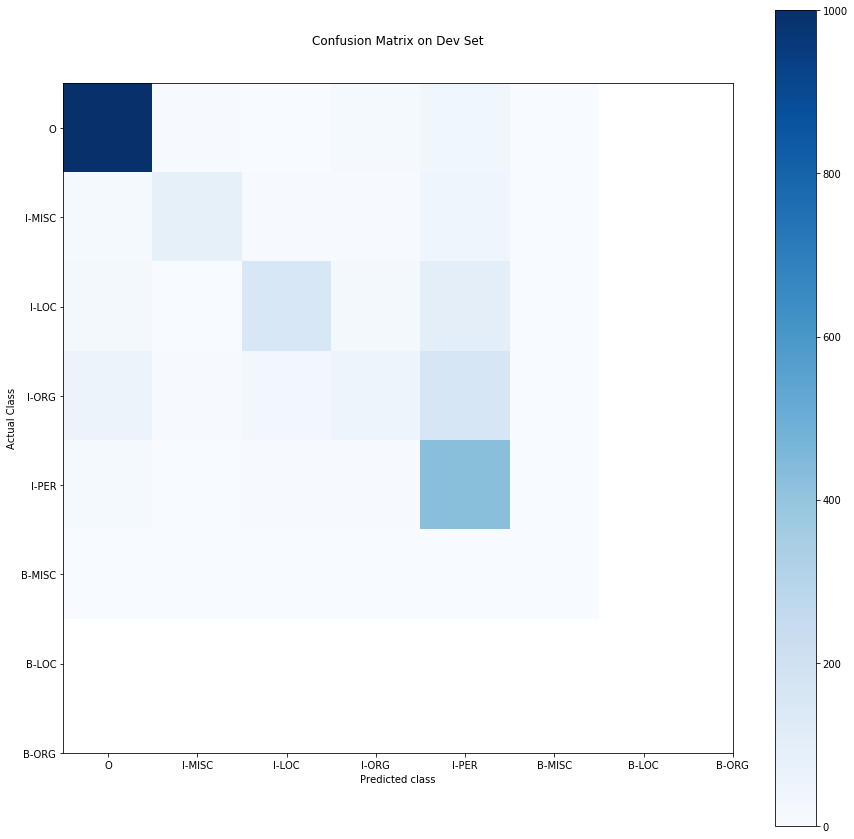

<Figure size 1080x1080 with 0 Axes>

In [235]:
plot_confusion_matrix(cnf_matrix, ner_tags_list, "Confusion Matrix on Dev Set", "cnf_dev_bg")

In [236]:
cnf_matrix

array([[6075,    4,    3,   13,   39,    0],
       [  13,   84,    6,    7,   40,    0],
       [  18,    2,  154,   18,  100,    0],
       [  54,    5,   26,   48,  159,    0],
       [  13,    1,    4,    6,  422,    0],
       [   0,    0,    0,    0,    1,    0]])

In [237]:
acc

0.9272727272727272

In [255]:
# # perceptron training on training data, T is the number of iterations

# def perceptron_training(train_feature_label, dev_feature_label, T):
    
#     count = 0
#     with open('weights__corrected__18', 'rb') as g1:
#         weights = pkl.load(g1)
#     print (weights.shape)
#     print (weights)
#     for i in range(20, T):
#         print ("Iteration: ", i)
        
#         for j in range(len(train_feature_label.keys())):
            
#             gt_tag_indices = train_feature_label[j][1]
#             gt_feature_vec = train_feature_label[j][0]
            
#             pred_tag_indices = viterbi_decoding(train_sentences, train_feature_matrix, j, weights)
#             pred_feature_vec = get_feature_vector(train_sentences, train_feature_matrix, j, pred_tag_indices)
            
#             if gt_tag_indices != pred_tag_indices:
                
#                 weights = weights.reshape((1, len(features_dict.keys())))
#                 weights = weights + gt_feature_vec - pred_feature_vec
#                 count += 1
# #                 print (weightss.shape, "weights shape")
                
#             if j%250 == 0:
#                 print (pred_tag_indices, "----", gt_tag_indices)
                
#         if (i%2) == 0:
#             with open("weights__corrected__" + str(i), 'wb') as f1:
#                 pkl.dump(weights, f1)

#     weights /= count
#     return weights

In [ ]:
# weights = perceptron_training(train_feature_label, dev_feature_label, 40)

In [243]:
# this creates training & validation data for perceptron learning. The outputs are dictionaries containing
# feature vector and NER tags for all sentences (train & dev)
def create_test_dict(dev_sentences, dev_feature_matrix):
    
    N = len(ner_tags_list)
    dev_feature_label = {}    
        
    for i in range(len(dev_sentences)):
        
        gt_labels = []
        sentence = dev_sentences[i]
        count_tokens = len(sentence)
        for token in sentence:
            gt_labels.append(ner_tags_list.index(token[3]))
            
        gt_feature = get_feature_vector(dev_sentences, dev_feature_matrix, i, gt_labels)
        dev_feature_label[i] = (gt_feature, gt_labels)
        
    return dev_feature_label

In [244]:
test_feature_label = create_test_dict(test_sentences, test_feature_matrix)

In [245]:
acc_test, cnf_matrix_test = get_confusion_matrix(test_sentences, test_feature_matrix, test_feature_label)

/home/lilly/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


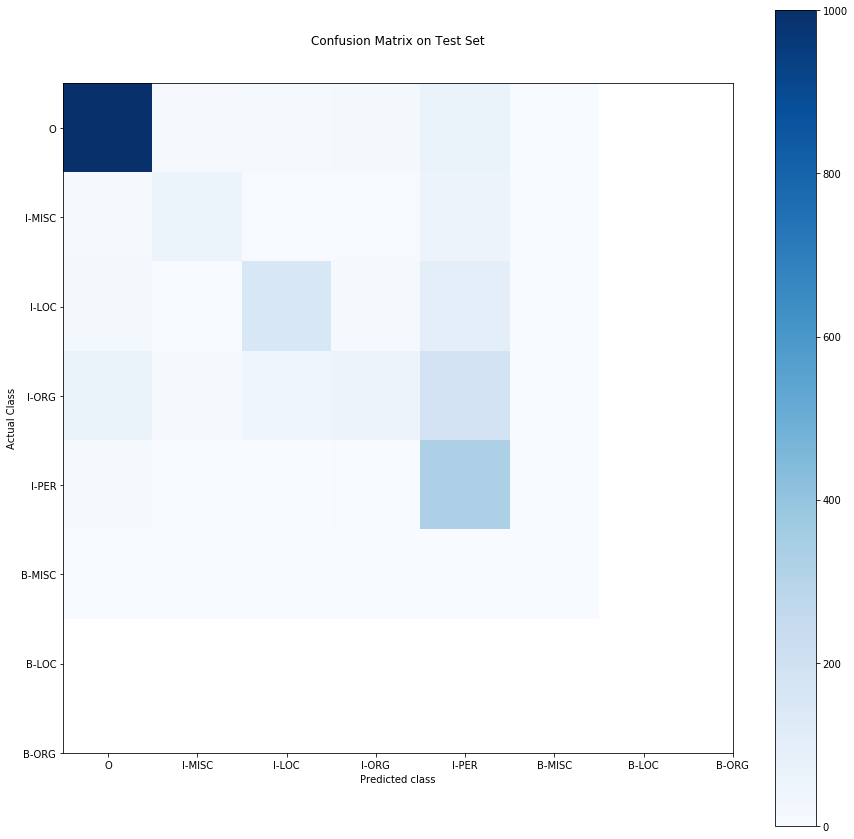

<Figure size 1080x1080 with 0 Axes>

In [246]:
plot_confusion_matrix(cnf_matrix_test, ner_tags_list, "Confusion Matrix on Test Set", "cnf_dev_bg")

In [257]:
acc_test

0.8981614708233413

In [258]:
cnf_matrix_test

array([[5020,    9,   14,   18,   66,    0],
       [  10,   62,    5,    6,   55,    0],
       [  18,    1,  154,   14,  101,    0],
       [  65,    8,   40,   57,  180,    0],
       [  14,    1,    3,    5,  325,    0],
       [   0,    1,    0,    1,    2,    0]])